In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import talib
import json
import requests

import numpy as np
import os
import gc

In [2]:
# trade to minute
# klineList = []
# for filename in os.listdir("./binance_swap_trade/")[:2]:
#     if filename.endswith('csv'):
#         tmp_trade = pd.read_csv("./binance_swap_trade/" + filename)

#         tmp_trade.columns = ['price', 'volume', 'action', 'time']
#         tmp_trade['time'] = pd.to_datetime(tmp_trade['time'], unit='ms')
#         tmp_trade.set_index('time', inplace=True)
#         for col in ['open', 'high', 'low', 'close']:
#             tmp_trade[col] = tmp_trade['price']
#         tmp_trade['turnover'] = tmp_trade['price'] * tmp_trade['volume']
#         tmp_min_df = tmp_trade.resample('1min').agg(
#             {
#                 "open": 'first',
#                 'high': 'max',
#                 'low': 'min',
#                 'close': 'last',
#                 "volume": 'sum',
#                 "turnover": 'sum'
#             }
#         ).round(3)[['open', 'high', 'low', 'close', 'volume', 'turnover']]
#         klineList.append(tmp_min_df)
#         del tmp_trade
#         del tmp_min_df
#         gc.collect()

# kline_df = pd.concat(klineList)
# kline_df

# kline_df.to_csv('binance_swap_kline.BTCUSDT.from_trade.csv')

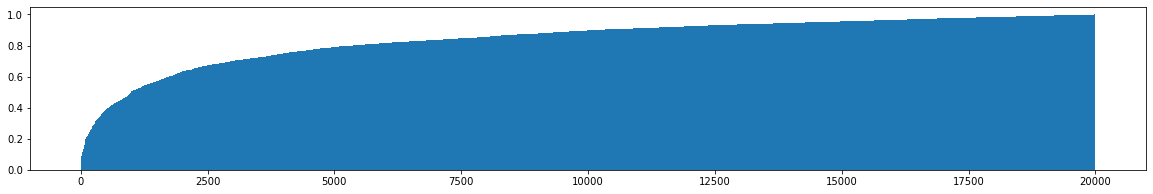

In [8]:
# plt.figure(figsize=(20, 3))
# ax = plt.axes()
# # vector, bins, patches = ax.hist(trade_df['turnover'].values, bins=1000, range=(0, 10000))
# vector, bins, patches = ax.hist(trade_df['turnover'].values, bins=1000, range=(5, 20000), cumulative=True, density=True)

In [47]:
# def get_threshold(vector, bins):
#     pos = 0
#     for i in range(len(vector)):
#         if vector[i] > 0.3:
#             th_1 = int(bins[i])
#             pos = i
#             break

#     for i in range(pos, len(vector)):
#         if vector[i] > 0.6:
#             th_2 = int(bins[i])
#             pos = i
#             break

#     for i in range(pos, len(vector)):
#         if vector[i] > 0.9:
#             th_3 = int(bins[i])
#             pos = i
#             break


#     print("turnover threshold 1:", th_1)
#     print("turnover threshold 2:", th_2)
#     print("turnover threshold 3:", th_3)
    
#     return th_1, th_2, th_3

In [2]:
# th_1, th_2, th_3, th_4 = get_threshold(vector, bins)
th_1, th_2, th_3 = 5000, 10000, 15000

In [3]:
# 散户主动做多
def getSmallOrderBuy(df):
    return df[
        (df['turnover'] < th_1) & (df['action'] == 'BUY') 
    ][['volume', 'turnover']].sum().rename({'volume': 'SmallBuyOrderVolume', 'turnover': 'SmallBuyOrderTurnover'})

# 散户主动做空
def getSmallOrderSell(df):
    return df[
        (df['turnover'] < th_1) & (df['action'] == 'SELL') 
    ][['volume', 'turnover']].sum().rename({'volume': 'SmallSellOrderVolume', 'turnover': 'SmallSellOrderTurnover'})

# 中户主动做多
def getMediumOrderBuy(df):
    return df[
        (df['turnover'] >= th_1) & (df['turnover'] < th_2) & (df['action'] == 'BUY') 
    ][['volume', 'turnover']].sum().rename({'volume': 'MediumBuyOrderVolume', 'turnover': 'MediumBuyOrderTurnover'})

# 中户主动做空
def getMediumOrderSell(df):
    return df[
        (df['turnover'] >= th_1) & (df['turnover'] < th_2) & (df['action'] == 'SELL') 
    ][['volume', 'turnover']].sum().rename({'volume': 'MediumSellOrderVolume', 'turnover': 'MediumSellOrderTurnover'})

# 大户主动做多
def getLargeOrderBuy(df):
    return df[
        (df['turnover'] >= th_2) & (df['turnover'] < th_3) & (df['action'] == 'BUY') 
    ][['volume', 'turnover']].sum().rename({'volume': 'LargeBuyOrderVolume', 'turnover': 'LargeBuyOrderTurnover'})

# 大户主动做空
def getLargeOrderSell(df):
    return df[
        (df['turnover'] >= th_2) & (df['turnover'] < th_3) & (df['action'] == 'SELL') 
    ][['volume', 'turnover']].sum().rename({'volume': 'LargeSellOrderVolume', 'turnover': 'LargeSellOrderTurnover'})

# 特大户主动做多
def getSuperLargeOrderBuy(df):
    return df[
        (df['turnover'] >= th_3) & (df['action'] == 'BUY') 
    ][['volume', 'turnover']].sum().rename({'volume': 'SuperLargeBuyOrderVolume', 'turnover': 'SuperLargeBuyOrderTurnover'})

# 特大户主动做空
def getSuperLargeOrderSell(df):
    return df[
        (df['turnover'] >= th_3) & (df['action'] == 'SELL') 
    ][['volume', 'turnover']].sum().rename({'volume': 'SuperLargeSellOrderVolume', 'turnover': 'SuperLargeSellOrderTurnover'})

activeOrderFuncList = [
    getSmallOrderBuy, getSmallOrderSell,
    getMediumOrderBuy, getMediumOrderSell,
    getLargeOrderBuy, getLargeOrderSell,
    getSuperLargeOrderBuy, getSuperLargeOrderSell
]

In [4]:
for filename in os.listdir("./binance_swap_trade/"):
    if filename.endswith('csv'):
        datestr = filename.split(".")[-2]
        print("\r" + datestr, end="")
        trade_df = pd.read_csv("./binance_swap_trade/" + filename)
        trade_df.columns = ['price', 'volume', 'action', 'time']
        trade_df['time'] = pd.to_datetime(trade_df['time'], unit='ms')
        trade_df.set_index('time', inplace=True)
        trade_df['turnover'] = (trade_df['price'] * trade_df['volume']).round(3)

        MoneyFlow_df_list = []
        for func in activeOrderFuncList:
            tmp_df = trade_df.groupby(pd.Grouper(freq='1min')).apply(func)
            MoneyFlow_df_list.append(tmp_df)

        MoneyFlow_df = pd.concat(MoneyFlow_df_list, axis=1)

        MoneyFlow_df['NetSuperLargeBuyTurnover'] = MoneyFlow_df['SuperLargeBuyOrderTurnover'] - MoneyFlow_df['SuperLargeSellOrderTurnover']
        MoneyFlow_df['NetLargeBuyTurnover'] = MoneyFlow_df['LargeBuyOrderTurnover'] - MoneyFlow_df['LargeSellOrderTurnover']
        MoneyFlow_df['NetMediumBuyTurnover'] = MoneyFlow_df['MediumBuyOrderTurnover'] - MoneyFlow_df['MediumSellOrderTurnover']
        MoneyFlow_df['NetSmallBuyTurnover'] = MoneyFlow_df['SmallBuyOrderTurnover'] - MoneyFlow_df['SmallSellOrderTurnover']

        MoneyFlow_df['NetSuperLargeBuyVolume'] = MoneyFlow_df['SuperLargeBuyOrderVolume'] - MoneyFlow_df['SuperLargeSellOrderVolume']
        MoneyFlow_df['NetLargeBuyVolume'] = MoneyFlow_df['LargeBuyOrderVolume'] - MoneyFlow_df['LargeSellOrderVolume']
        MoneyFlow_df['NetMediumBuyVolume'] = MoneyFlow_df['MediumBuyOrderVolume'] - MoneyFlow_df['MediumSellOrderVolume']
        MoneyFlow_df['NetSmallBuyVolume'] = MoneyFlow_df['SmallBuyOrderVolume'] - MoneyFlow_df['SmallSellOrderVolume']

        # 净流入金额
        MoneyFlow_df['NetFlowTurnover'] = MoneyFlow_df[['NetSuperLargeBuyTurnover', 'NetLargeBuyTurnover', 'NetMediumBuyTurnover', 'NetSmallBuyTurnover']].sum(axis=1)

        # 净流入量
        MoneyFlow_df['NetFlowVolume'] = MoneyFlow_df[['NetSuperLargeBuyVolume', 'NetLargeBuyVolume', 'NetMediumBuyVolume', 'NetSmallBuyVolume']].sum(axis=1)

        # 总交易量
        MoneyFlow_df['volume'] = MoneyFlow_df[
            [
                'SuperLargeBuyOrderVolume', 'SuperLargeSellOrderVolume', 'LargeBuyOrderVolume', 'LargeSellOrderVolume',
                'MediumBuyOrderVolume', 'MediumSellOrderVolume', 'SmallBuyOrderVolume', 'SmallSellOrderVolume'
            ]
        ].sum(axis=1)

        # 总交易额
        MoneyFlow_df['turnover'] = MoneyFlow_df[
            [
                'SuperLargeBuyOrderTurnover', 'SuperLargeSellOrderTurnover', 'LargeBuyOrderTurnover', 'LargeSellOrderTurnover',
                'MediumBuyOrderTurnover', 'MediumSellOrderTurnover', 'SmallBuyOrderTurnover', 'SmallSellOrderTurnover'
            ]
        ].sum(axis=1)

        # 净流入率（金额）
        MoneyFlow_df['NetFlowTurnover_Rate'] = MoneyFlow_df['NetFlowTurnover'] / MoneyFlow_df['turnover']

        # 大单净流入量
        MoneyFlow_df['LargeOrderVolume'] = MoneyFlow_df['NetSuperLargeBuyVolume'] + MoneyFlow_df['NetLargeBuyVolume']
        # 大单净流入金额
        MoneyFlow_df['LargeOrderTurnover'] = MoneyFlow_df['NetSuperLargeBuyTurnover'] + MoneyFlow_df['NetLargeBuyTurnover']
        # 大单流入率(金额)
        MoneyFlow_df['NetFlowLargeOrderTurnover_Rate'] = MoneyFlow_df['LargeOrderTurnover'] / MoneyFlow_df['turnover']

        # 小单净流入量
        MoneyFlow_df['SmallOrderVolume'] = MoneyFlow_df['NetSmallBuyVolume'] + MoneyFlow_df['NetMediumBuyVolume']
        # 小单净流入金额
        MoneyFlow_df['SmallOrderTurnover'] = MoneyFlow_df['NetSmallBuyTurnover'] + MoneyFlow_df['NetMediumBuyTurnover']
        # 小单流入率(金额)
        MoneyFlow_df['NetFlowSmallOrderTurnover_Rate'] = MoneyFlow_df['SmallOrderTurnover'] / MoneyFlow_df['turnover']

        # 主动做多量
        MoneyFlow_df['BuyOrderVolume'] = MoneyFlow_df[['SmallBuyOrderVolume', 'MediumBuyOrderVolume', 'LargeBuyOrderVolume', 'SuperLargeBuyOrderVolume']].sum(axis=1)
        # 主动做空量
        MoneyFlow_df['SellOrderVolume'] = MoneyFlow_df[['SmallSellOrderVolume', 'MediumSellOrderVolume', 'LargeSellOrderVolume', 'SuperLargeSellOrderVolume']].sum(axis=1)

        # 合约多空比
        MoneyFlow_df['LongShortRatio'] = MoneyFlow_df['BuyOrderVolume'] / MoneyFlow_df['SellOrderVolume']

        MoneyFlow_df.round(3).to_csv('./binance_swap_MoneyFlowFactor/{}.csv'.format(datestr))
        
        del trade_df
        gc.collect()

20201217

In [8]:
money_flow_df_list = []
for filename in os.listdir('./binance_swap_MoneyFlowFactor/'):
    if filename.endswith('.csv'):
        df = pd.read_csv('./binance_swap_MoneyFlowFactor/' + filename, index_col=0)
        money_flow_df_list.append(df)
money_flow_df = pd.concat(money_flow_df_list)

In [10]:
# 主动做多移动平均(5min)-收益率(3min)
money_flow_df['ReturnRate_MA_5_BuyOrderVolume'] = money_flow_df['BuyOrderVolume'].rolling(5).mean().pct_change(3).fillna(0)

# 主动做空移动平均(5min)-收益率(3min)
money_flow_df['ReturnRate_MA_5_SellOrderVolume'] = money_flow_df['SellOrderVolume'].rolling(5).mean().pct_change(3).fillna(0)

# 合约多空比收益率
money_flow_df['ReturnRate_LongShortRatio'] = money_flow_df['LongShortRatio'].pct_change().fillna(0)

In [12]:
money_flow_df.round(3).to_csv('./moneyflow.csv')

In [17]:
kline = pd.read_csv('binance_swap_kline.BTCUSDT.from_trade.csv', index_col=0)

In [18]:
interval= 5
kline['vwap'] = (kline['turnover'] / kline['volume']).round(2)
kline['label'] = kline['vwap'].pct_change(periods=interval).shift(-interval)

In [21]:
money_flow_corr = money_flow_df.join(kline['label']).dropna().corr()

In [22]:
money_flow_corr.round(3).to_csv('money_factor_corr.csv')